# Team Gear5 - ADA 2024 Project  


**Authors:** Mahmoud Dokmak, Matthieu Borello, Loïc Domingos, Léo Bruneau, Bastien Armstrong

<hr style="clear:both">

## Part 1 - Combining the datasets

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import warnings
#warnings.filterwarnings('ignore')
from openpyxl.styles.builtins import title
from scipy.stats import ttest_ind
from collections import Counter
from scipy.stats import chi2_contingency
import requests
import shutil
import zipfile
from urllib.parse import urlparse


In [15]:
def print_df_size(name, df):
	print(name, f"- shape: {df.shape} --> {df.shape[0]} rows and {df.shape[1]} columns")

Need to implement generalized function or folder to download and extract zip to folders 

In [16]:
def download_and_extract(url, extract_to='data', folder_to_delete=None):
    file_name = os.path.basename(urlparse(url).path)
    download_path = os.path.join(extract_to, file_name)
    os.makedirs(extract_to, exist_ok=True)

    print(f"Downloading file from {url}...")
    response = requests.get(url)
    if response.status_code == 200:
        with open(download_path, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded successfully to {download_path}")
    else:
        raise Exception(f"Failed to download file. Status code: {response.status_code}")
    if zipfile.is_zipfile(download_path):
        print(f"Extracting {file_name}...")
        with zipfile.ZipFile(download_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Files extracted to {extract_to}")

    else:
        print(f"{file_name} is not a zip file. No extraction needed.")
        return
    if folder_to_delete:
        folder_to_delete_path = os.path.join(extract_to, folder_to_delete)
        if os.path.isdir(folder_to_delete_path):
            shutil.rmtree(folder_to_delete_path)
            print(f"Deleted folder: {folder_to_delete_path}")
        else:
            print(f"Folder '{folder_to_delete}' not found in {extract_to}.")


url_movie_dataset_public = "https://files.grouplens.org/datasets/tag-genome-2021/genome_2021.zip" 
download_and_extract(url_movie_dataset_public, extract_to="data", folder_to_delete="__MACOSX")

File downloaded successfully to data\genome_2021.zip
Extracting genome_2021.zip...
Files extracted to data
Deleted folder: data\__MACOSX


In [17]:
data_movies = pd.read_csv('./data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
data_movies.columns = ['wiki_movie_id','freebase_movie_id','movie_name','release_date','box_office','run_time', 'language', 'country_origin','genre']
print_df_size("data of movies", data_movies)

data of movies - shape: (81741, 9) --> 81741 rows and 9 columns


In [18]:
data_movies['wiki_movie_id']
print(type(data_movies['wiki_movie_id'].iloc[0]))
data_movies.head(10)

<class 'numpy.int64'>


,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office,run_time,language,country_origin,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant..."
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ..."
8,9997961,/m/06_y2j7,Contigo y aquí,1974,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",..."
9,2345652,/m/075f66,City of the Dead,1960,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur..."


In [19]:
added_movies = pd.read_json('./data/movie_dataset_public_final/raw/metadata_updated.json', lines=True)
print_df_size("added movies", added_movies)

added movies - shape: (84661, 6) --> 84661 rows and 6 columns


In [20]:
added_movies["imdbId"]
print(type(added_movies["imdbId"].iloc[0]))
added_movies.head(10)

<class 'numpy.int64'>


,title,directedBy,starring,avgRating,imdbId,item_id
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney,...",3.89146,114709,1
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams,...",3.26605,113497,2
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sop...",3.17146,113228,3
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Housto...",2.86824,114885,4
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimb...",3.07620,113041,5
5,Heat (1995),Michael Mann,"Robert De Niro, Al Pacino, Val Kilmer, Jon Voi...",3.85549,113277,6
6,Sabrina (1995),Sydney Pollack,"Harrison Ford, Greg Kinnear, Nancy Marchand, J...",3.37244,114319,7
7,Tom and Huck (1995),Peter Hewitt,"Jonathan Taylor Thomas, Brad Renfro, Eric Schw...",3.11678,112302,8
8,Sudden Death (1995),Peter Hyams,"Raymond J. Barry, Powers Boothe, Jean-Claude V...",3.00242,114576,9
9,GoldenEye (1995),Martin Campbell,"Pierce Brosnan, Sean Bean, Famke Janssen, Izab...",3.43340,113189,10


In [21]:
added_movies["imdbId"] = added_movies["imdbId"].astype(str)
print(type(added_movies["imdbId"].iloc[0]))
added_movies.head(10)

<class 'str'>


,title,directedBy,starring,avgRating,imdbId,item_id
0,Toy Story (1995),John Lasseter,"Tim Allen, Tom Hanks, Don Rickles, Jim Varney,...",3.89146,114709,1
1,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams,...",3.26605,113497,2
2,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sop...",3.17146,113228,3
3,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Housto...",2.86824,114885,4
4,Father of the Bride Part II (1995),Charles Shyer,"Steve Martin, Martin Short, Diane Keaton, Kimb...",3.07620,113041,5
5,Heat (1995),Michael Mann,"Robert De Niro, Al Pacino, Val Kilmer, Jon Voi...",3.85549,113277,6
6,Sabrina (1995),Sydney Pollack,"Harrison Ford, Greg Kinnear, Nancy Marchand, J...",3.37244,114319,7
7,Tom and Huck (1995),Peter Hewitt,"Jonathan Taylor Thomas, Brad Renfro, Eric Schw...",3.11678,112302,8
8,Sudden Death (1995),Peter Hyams,"Raymond J. Barry, Powers Boothe, Jean-Claude V...",3.00242,114576,9
9,GoldenEye (1995),Martin Campbell,"Pierce Brosnan, Sean Bean, Famke Janssen, Izab...",3.43340,113189,10


In [22]:
converter = pd.read_csv('./data/Converter/query.csv')
print_df_size("converter", converter)

converter - shape: (409064, 2) --> 409064 rows and 2 columns


In [23]:
print(type(converter["imdb_id"].iloc[0]))
print(type(converter["freebase_id"].iloc[0]))
converter.head(10)

<class 'str'>
<class 'str'>


,imdb_id,freebase_id
0,nm0010930,/m/0282x
1,nm0124133,/m/09b6zr
2,nm0684496,/m/014d3
3,nm0061667,/m/01rgr
4,tt1675434,/m/0hgqwpj
5,nm0949918,/m/0m2l9
6,nm0180134,/m/0fyh4
7,nm0001789,/m/0hy8
8,nm0686817,/m/05qmj
9,nm0000658,/m/0h0wc


In [24]:
converter["imdb_id"] = converter["imdb_id"].str[3:]
converter.head(10)

,imdb_id,freebase_id
0,010930,/m/0282x
1,124133,/m/09b6zr
2,684496,/m/014d3
3,061667,/m/01rgr
4,675434,/m/0hgqwpj
5,949918,/m/0m2l9
6,180134,/m/0fyh4
7,001789,/m/0hy8
8,686817,/m/05qmj
9,000658,/m/0h0wc


In [25]:
merged_data = pd.merge(data_movies, converter, left_on="freebase_movie_id", right_on="freebase_id", how='left')

data_movies['imdb_id'] = merged_data["imdb_id"]



In [26]:
data_movies.head(20)

,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office,run_time,language,country_origin,genre,imdb_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",228333
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",245916
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",094806
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",094320
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",083949
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",002894
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...",NaN
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",029852
8,9997961,/m/06_y2j7,Contigo y aquí,1974,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",...",200545
9,2345652,/m/075f66,City of the Dead,1960,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur...",053719


In [27]:
final_data = pd.merge(data_movies, added_movies, left_on='imdb_id', right_on="imdbId", how='left')
final_data.head(20)

,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office,run_time,language,country_origin,genre,imdb_id,title,directedBy,starring,avgRating,imdbId,item_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",228333,Ghosts of Mars (2001),John Carpenter,"Natasha Henstridge, Ice Cube, Jason Statham, C...",2.35723,228333,4735.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",245916,NaN,NaN,NaN,NaN,NaN,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",094806,NaN,NaN,NaN,NaN,NaN,NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",094320,NaN,NaN,NaN,NaN,NaN,NaN
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",083949,NaN,NaN,NaN,NaN,NaN,NaN
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",002894,NaN,NaN,NaN,NaN,NaN,NaN
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",029852,NaN,NaN,NaN,NaN,NaN,NaN
8,9997961,/m/06_y2j7,Contigo y aquí,1974,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",...",200545,NaN,NaN,NaN,NaN,NaN,NaN
9,2345652,/m/075f66,City of the Dead,1960,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur...",053719,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
filtered_final_data = final_data.dropna(subset=['imdbId'])
# Drop the rows with empty country lists as well as languages in order to perform analysis
filtered_final_data = filtered_final_data.dropna(subset=['country_origin'])
filtered_final_data = filtered_final_data.dropna(subset=['language'])
filtered_final_data = filtered_final_data.drop(columns=['title', 'starring'])
filtered_final_data

,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office,run_time,language,country_origin,genre,imdb_id,directedBy,avgRating,imdbId,item_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",228333,John Carpenter,2.35723,228333,4735.0
12,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...",119548,Roberto Benabib,3.00000,119548,1782.0
14,18296435,/m/04cqrs4,Aaah Belinda,1986,NaN,NaN,"{""/m/02hwyss"": ""Turkish Language""}","{""/m/01znc_"": ""Turkey""}","{""/m/01z4y"": ""Comedy""}",278891,Atıf Yılmaz,4.50000,278891,236345.0
21,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",133122,Abel Ferrara,2.47790,133122,2892.0
22,21926710,/m/05p45cv,White on Rice,2009,NaN,82.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",892904,Dave Boyle,2.00000,892904,90777.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81715,29449643,/m/0ds22f6,Muthukku Muthaaga,NaN,NaN,147.0,{},{},"{""/m/05p553"": ""Comedy film""}",112818,Tim Robbins,3.92470,112818,36.0
81721,34474142,/m/0cpy07r,Frontier Fury,1943-06-24,NaN,55.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hfjk"": ""Western""}",105017,Peter Bogdanovich,3.74934,105017,7647.0
81724,19286279,/m/04ldgm4,Kalai Arasi,1963-04-19,NaN,NaN,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}","{""/m/02l7c8"": ""Romance Film"", ""/m/02kdv5l"": ""A...",119051,Lee Tamahori,3.49208,119051,1615.0
81730,31353375,/m/0gkz70w,The Luck of the Navy,1927-11-22,NaN,110.0,{},"{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/06ppq"": ""Silent ...",477392,Steven Goldmann,3.50000,477392,129311.0


In [29]:
print_df_size("final data", filtered_final_data)

final data - shape: (14770, 16) --> 14770 rows and 16 columns


In [30]:
# Count the number of NaN values in the fourth column (index 3)
nan_count = filtered_final_data.iloc[:, 5].isna().sum()

# Print the count
print(nan_count)

3775


In [31]:
reviews_df = pd.read_json('./data/movie_dataset_public_final/raw/reviews.json', lines=True)
reviews_df.head(10)

,item_id,txt
0,172063,"one-shot record of a belly dancer; ""Carmencita..."
1,95541,Banging Away..; Thomas Edison and William K.L....
2,7065,unbelievable; I cannot understand how anyone c...
3,3739,I'm still starry-eyed from it; I saw this last...
4,1562,Failed on every Front; Joel Schumacher who did...
5,8977,"Poor Casting, Poor script Poor direction.; I h..."
6,2174,An Accomplished Tim Burton Movie; A Great Idea...
7,8947,"Very good; I saw ""The Grudge"" yesterday, and w..."
8,143027,This movie was stupid.; This movie was totally...
9,143027,. . . is a great movie.; Amazing! Finally Disn...


In [32]:
# For faster loading and saving, we will save the dataframe as a pickle file
reviews_df.to_pickle('./data/reviews.pkl')

In [33]:
reviews_with_titles = pd.merge(reviews_df, filtered_final_data[['item_id', 'title']], on='item_id', how='left')
reviews_with_titles.dropna(subset=['title'], inplace=True)
reviews_with_titles

,item_id,txt,title
4,1562,Failed on every Front; Joel Schumacher who did...,Batman & Robin (1997)
5,1562,Failed on every Front; Joel Schumacher who did...,Batman & Robin (1997)
6,8977,"Poor Casting, Poor script Poor direction.; I h...",Alexander (2004)
8,8947,"Very good; I saw ""The Grudge"" yesterday, and w...","Grudge, The (2004)"
9,143027,This movie was stupid.; This movie was totally...,Now You See It... (2005)
...,...,...,...
2641618,520,"Aims low, with hilarious results; ROBIN HOOD: ...",Robin Hood: Men in Tights (1993)
2641619,8640,Worst epic of 2004; I usually love big epics i...,King Arthur (2004)
2641620,1377,superb Second Movie; I was glad to see that Ti...,Batman Returns (1992)
2641621,26746,Seagal takes out the garbage; This is hard cor...,Out for Justice (1991)


In [34]:
merged_reviews = pd.merge(filtered_final_data, reviews_df, left_on='item_id', right_on='item_id', how='inner')
print_df_size("merged reviews", merged_reviews)
merged_reviews.head(10)
merged_reviews.isna().sum()


merged reviews - shape: (1299897, 17) --> 1299897 rows and 17 columns


wiki_movie_id              0
freebase_movie_id          0
movie_name                 0
release_date          113284
box_office           1167936
run_time              335866
language                   0
country_origin             0
genre                      0
imdb_id                    0
title                      0
directedBy                 0
starring                   0
avgRating                  0
imdbId                     0
item_id                    0
txt                        0
dtype: int64

In [35]:
merged_reviews
#somethung is wrong with the data, we need to check the data and see why there are mismatched values

,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office,run_time,language,country_origin,genre,imdb_id,title,directedBy,starring,avgRating,imdbId,item_id,txt
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",228333,Ghosts of Mars (2001),John Carpenter,"Natasha Henstridge, Ice Cube, Jason Statham, C...",2.35723,228333,4735.0,Pretty Good; On the planet Mars in the not-too...
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",228333,Ghosts of Mars (2001),John Carpenter,"Natasha Henstridge, Ice Cube, Jason Statham, C...",2.35723,228333,4735.0,Quatermass influence; I have not read all the ...
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",228333,Ghosts of Mars (2001),John Carpenter,"Natasha Henstridge, Ice Cube, Jason Statham, C...",2.35723,228333,4735.0,Dreary stuff; GHOSTS OF MARS Aspect ratio: 2.3...
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",228333,Ghosts of Mars (2001),John Carpenter,"Natasha Henstridge, Ice Cube, Jason Statham, C...",2.35723,228333,4735.0,Please stop watching Carpenter if you hate his...
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",228333,Ghosts of Mars (2001),John Carpenter,"Natasha Henstridge, Ice Cube, Jason Statham, C...",2.35723,228333,4735.0,Entertaining Time Killer But Nothing More Then...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299892,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",876563,Ponyo (Gake no ue no Ponyo) (2008),Hayao Miyazaki,"Yuria Nara, Tomoko Yamaguchi, Yuki Amami, Geor...",3.84285,876563,65261.0,A Tsunami of Emotions from Master Miyazaki...;...
1299893,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",876563,Ponyo (Gake no ue no Ponyo) (2008),Hayao Miyazaki,"Yuria Nara, Tomoko Yamaguchi, Yuki Amami, Geor...",3.84285,876563,65261.0,"Being Human; Rescued by a human boy, an inquis..."
1299894,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",876563,Ponyo (Gake no ue no Ponyo) (2008),Hayao Miyazaki,"Yuria Nara, Tomoko Yamaguchi, Yuki Amami, Geor...",3.84285,876563,65261.0,A boyhood adventure; Ponyo is a Japanese anima...
1299895,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",876563,Ponyo (Gake no ue no Ponyo) (2008),Hayao Miyazaki,"Yuria Nara, Tomoko Yamaguchi, Yuki Amami, Geor...",3.84285,876563,65261.0,"Watch the trailer, you can decide from there i..."


## Proof of concepts for the methods

In this section, we want to show simple examples of the methods we are going to use in our project to prove that they work. Of course, the cases we are going to be analyzing in the final project are going to be more complex then these examples, but this serves only as a proof of concept. 

### Part 1 - Change point analysis

#### Model used for sentiment analysis example 
Labels: 0 -> Negative; 1 -> Neutral; 2 -> Positive

In [3]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# Loading a Pre-Trained Model from HuggingFace Hub
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

# Creating a Function to Run the Application
def run_classification(text):
    result = classifier(text)
    return result

# Running the Application
input_text = "I love using HuggingFace models for NLP tasks!"
pos_result = run_classification(input_text)
print(f"Input: {input_text}")
print(f"Classification: {pos_result}")

c:\Users\basti\anaconda3\envs\ada\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Input: I love using HuggingFace models for NLP tasks!


NameError: name 'result' is not defined

Thus the score is quite positive, as the label is 2 ! Yay, that's exactly what we expected 

In [ ]:
input_text = "I hate handing in my assignments on the last day!"
neg_result = run_classification(input_text)
print(f"Input: {input_text}")
print(f"Classification: {neg_result}")

Input: I hate handing in my assignments on the last day!
Classification: [{'label': 'LABEL_0', 'score': 0.937169075012207}]


Here, as the lab is 0 it's a negative assessment...

In [ ]:
input_text = "The movie had a mix of strengths and weaknesses. Some aspects, like the cinematography, were well done, while others, such as the pacing, could have been improved"
neut_result = run_classification(input_text)
print(f"Input: {input_text}")
print(f"Classification: {neut_result}")

Input: The movie had a mix of strengths and weaknesses. Some aspects, like the cinematography, were well done, while others, such as the pacing, could have been improved
Classification: [{'label': 'LABEL_1', 'score': 0.49330204725265503}]


Once again on the mark !
We will thus implement this for our reviews.

### Part 2 - 

For part 2, we do not have any new method to implement, simply more specific plots.

### Part 3 - Predictive models

The first model we test in the polynomial regression

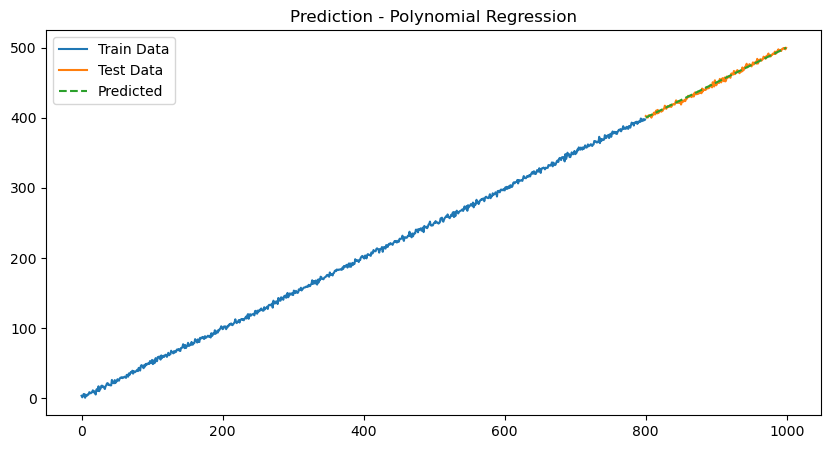

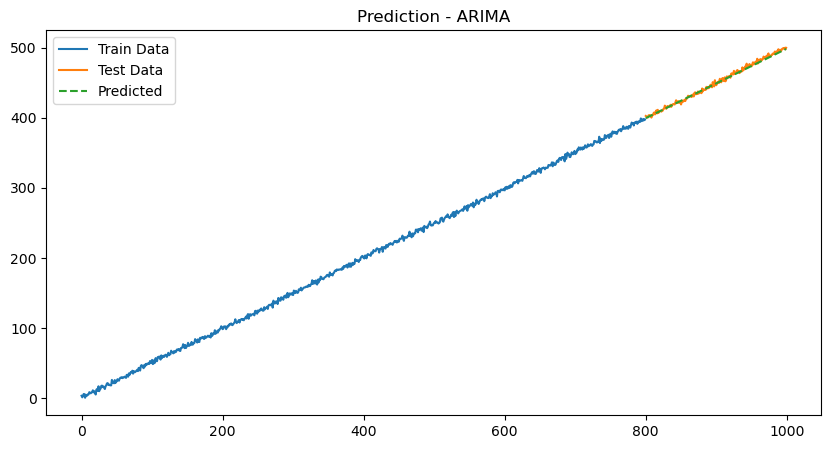

In [ ]:
from tests.PolynomialRegression import polynomial_regression
from tests.ARIMA import arima
from src.utils.print_prediction import plot_results

np.random.seed(0)
n = 1000
time_series = pd.Series(0.5 * np.arange(n) + np.sin(np.linspace(0, 20, n)) + np.random.normal(scale=2, size=n))
train, test = time_series[:800], time_series[800:]

poly_predictions = polynomial_regression(train, degree=3, n_forecast=len(test))
plot_results(train, test, poly_predictions, "Prediction - Polynomial Regression")

order = (50, 1, 50)  # (p,d,q)
# p is the number of previous points used to make the prediction
# d is the differentiating order to eliminate trends
# q is the moving average window

arima_predictions = arima(train, order=(2, 1, 2), n_forecast=len(test))
plot_results(train, test, arima_predictions, "Prediction - ARIMA")

One important thing to note is that the ARIMA model seem to be performing worse when the number of samples in the timeseries is smaller (See below). This could be an issue when using the year of release for movies. This problem might be resolved with a better initial choices of parameters for the model. However, if the issue persists, we might need to consider using the year and month for movie release to get more values in our timeseries.

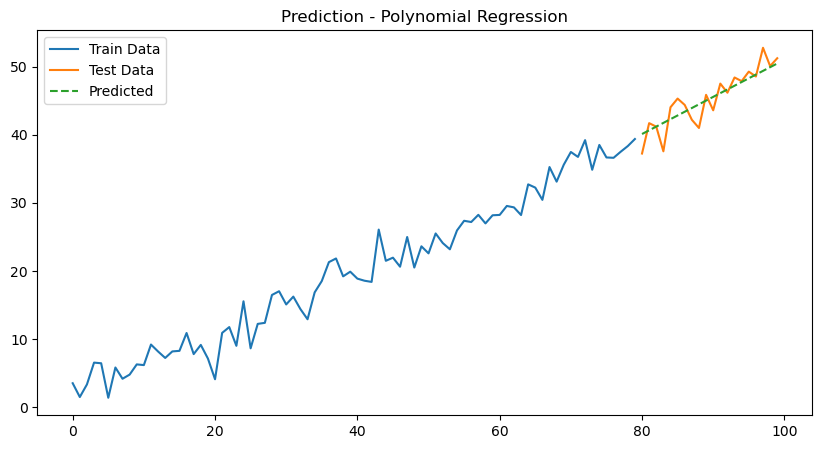

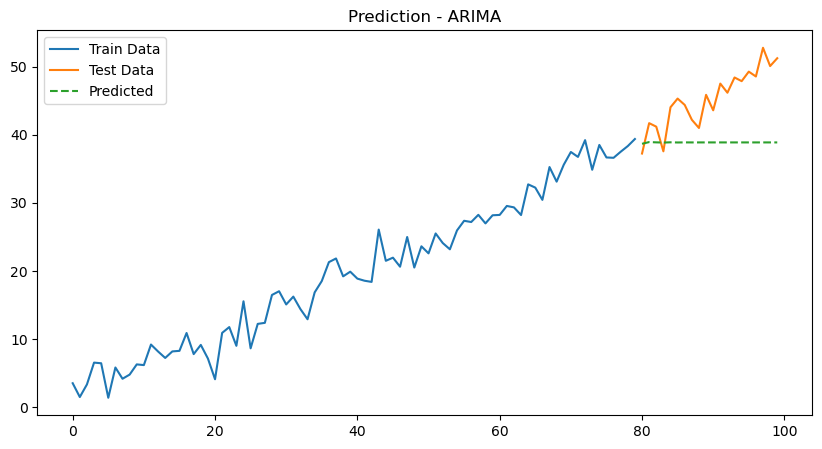

In [40]:
np.random.seed(0)
n = 100
time_series = pd.Series(0.5 * np.arange(n) + np.sin(np.linspace(0, 20, n)) + np.random.normal(scale=2, size=n))
train, test = time_series[:80], time_series[80:]

poly_predictions = polynomial_regression(train, degree=3, n_forecast=len(test))
plot_results(train, test, poly_predictions, "Prediction - Polynomial Regression")

order = (20, 1, 20) 

arima_predictions = arima(train, order=(2, 1, 2), n_forecast=len(test))
plot_results(train, test, arima_predictions, "Prediction - ARIMA")